# Label Defect Detection
This small project is part of my learning process and one of my experiments on defect detection using image classification with some preprocessing, which will serve as a baseline for other experiments.

Defects in small printed labels -- less than 5 mm in width and height -- often come in many forms: smudges, character defects, sticker defects, etc. With the labels being part of the product, it is importance to also ensure the quality of the labels in the quality control process. While defect detection approaches which I have surveyed usually involves a detector plus classifier structure (essentially an object detection task), I have been very curious as to how "simple" image classification would perform in such task (hence why I said this is part of my learning process).

In this notebook, I will be using transfer learning with **Inception ResNet V2** and techniques including applying **data augmentation** on the training set and **early stopping** in the training process. The resulting model will then be evaluated on the un-preprocessed testing set.

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.preprocessing import image
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
from tqdm import tqdm
import glob

### Image Preprocessing
#### **Read in Dataset**

In [ ]:
# Path to image dataset
sdir=r'A-ODT'

In [ ]:
# Put image file paths and associated labels into lists
filepaths = []
classpaths = []
labels = []
classlist = os.listdir(sdir)
for klass in classlist:
    classpath = os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath,f)
            classpaths.append(classpath)
            filepaths.append(fpath)
            labels.append(klass)

In [ ]:
# Create a dataframe for the dataset
Fseries = pd.Series(filepaths, name='filepaths')
Cseries = pd.Series(classpaths, name='classpaths')
Lseries = pd.Series(labels, name='labels')    
df = pd.concat([Fseries, Cseries, Lseries], axis=1)
print(df['labels'].value_counts())

OK    191
NG    180
Name: labels, dtype: int64


In the dataset, we have a total of 191 OK images and 180 NG images. Since this is a small dataset that covers a wide range of NG types, we will want to do some data augmentation to increase the diversity of our training set in the preprocessing step.

In [ ]:
# Perform train-test split
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)

train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=42, stratify=labels)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=42)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  296   test_df length:  37   valid_df length:  38


In [ ]:
print (len(train_df[train_df['labels'] == 'NG']))
print (len(test_df[test_df['labels'] == 'NG']))
print (len(valid_df[valid_df['labels'] == 'NG']))

144
17
19


In [ ]:
train_df.tail()

,filepaths,classpaths,labels
208,A-ODT/NG/TW1YX13701748-1338.jpg,A-ODT/NG,NG
104,A-ODT/OK/TW1YX13703144-2244.jpg,A-ODT/OK,OK
247,A-ODT/NG/TW1YX13605734.jpg,A-ODT/NG,NG
148,A-ODT/OK/TW1YX13703283-2378.jpg,A-ODT/OK,OK
220,A-ODT/NG/TW1YX13606182-338.jpg,A-ODT/NG,NG


#### **Data Preprocessing**
In the data preprocessing step, I'm applying the following transformations on the training set:


* Modify color temperature (warm & cold)
* Convert to grayscale image
* Increase brightness

I initially thought about using cropping, flipping, and rotation. However, after a few trial experiments, I noticed that these data augmentation options may not best suit my case. The input label images in the quality control process are all of (almost) fixed size and orientation, and introducing these options reduces the model's ability to accurately classify the images.


In [ ]:
# Helper function to alter the color channel of the image set
def modify_color_temperature(img, warm):
    imgB = img[:,:,0]
    imgG = img[:,:,1]
    imgR = img[:,:,2]
    
    if warm:
        bAvg = cv.mean(imgB)[0] + 20
        gAvg = cv.mean(imgG)[0] + 20
        rAvg = cv.mean(imgR)[0]
        avgGray = (int)(bAvg + gAvg + rAvg) / 3
    else:
        bAvg = cv.mean(imgB)[0]
        gAvg = cv.mean(imgG)[0] + 20
        rAvg = cv.mean(imgR)[0] + 20
        avgGray = (int)(bAvg + gAvg + rAvg) / 3
    
    bCoef = avgGray / bAvg
    gCoef = avgGray / gAvg
    rCoef = avgGray / rAvg
    imgB = np.floor((imgB * bCoef))
    imgG = np.floor((imgG * gCoef))
    imgR = np.floor((imgR * rCoef))
    
    imgb = imgB
    imgb[imgb > 255] = 255
    imgg = imgG
    imgg[imgg > 255] = 255
    imgr = imgR
    imgr[imgr > 255] = 255
    
    col_rgb = np.dstack((imgb, imgg, imgr)).astype(np.uint8)
    
    return col_rgb

# Helper function to further adjust the brightness of the images
def adjust_brightness(image):
    float_img = image.astype(np.float32)
    float_img = float_img / 255.0
    
    lightness = 25
    
    hls_img = cv.cvtColor(float_img, cv.COLOR_BGR2HLS)
    hls_img[:,:,1] = (1 + lightness / 100.0) * hls_img[:,:,1]
    hls_img[:,:,1][hls_img[:,:,1] > 1] = 1
    
    res_img = cv.cvtColor(hls_img, cv.COLOR_HLS2BGR)
    res_img = ((res_img * 255).astype(np.uint8))
    
    return res_img

In [ ]:
# Preprocess data and return a dataframe with augmented images
def preprocess_data(temp_df):
  data = []
  for index, row in temp_df.iterrows():
    img_path = row['filepaths']
    classpath = row['classpaths']
    label = row['labels']

    img = cv.imread(img_path)

    # Modify color temperature of images to warmer colors
    img_warm = modify_color_temperature(img, warm=True)
    img_warm_path = os.path.join(classpath, "mWarm_" + os.path.basename(img_path))
    cv.imwrite(img_warm_path, img_warm)

    # Modify color temperature of images to colder colors
    img_cold = modify_color_temperature(img, warm=False)
    img_cold_path = os.path.join(classpath, "mCold_" + os.path.basename(img_path))
    cv.imwrite(img_cold_path, img_cold)

    # Convert to grayscale
    img_gray = cv.imread(img_path, 0)
    img_gray_path = os.path.join(classpath, "g_" + os.path.basename(img_path))
    cv.imwrite(img_gray_path, img_gray)

    data.append([img_warm_path, classpath, label])
    data.append([img_cold_path, classpath, label])
    data.append([img_gray_path, classpath, label])

  for index, row in temp_df.iterrows():
    img_path = row['filepaths']
    classpath = row['classpaths']
    label = row['labels']

    img = cv.imread(img_path)

    # Adjust brightness for all training images (including augmented)
    img = adjust_brightness(img)
    img_bright_path = os.path.join(classpath, "b_" + os.path.basename(img_path))
    cv.imwrite(img_bright_path, img)

    data.append([img_bright_path, classpath, label])

  aug_df = pd.DataFrame(data, columns=['filepaths', 'classpaths', 'labels'])
  return aug_df

In [ ]:
# Generate the augmented dataframe for training set
aug_df = preprocess_data(train_df)
train_df = pd.concat([aug_df, train_df], ignore_index = True, axis = 0)
len(train_df)

1480

In [ ]:
print (len(train_df[train_df['labels'] == 'NG']))
print (len(test_df[test_df['labels'] == 'NG']))
print (len(valid_df[valid_df['labels'] == 'NG']))

720
17
19


After data augmentation, we can see that the number of images in our training set have greatly increased. **The validation set and testing set are untouched** since we wouold want our model to be trained on a diversed augmented data while being tested on "real" data.

In [ ]:
height = 128
width = 128

channels = 3
batch_size = 40
img_shape = (height, width, channels)
img_size = (height, width)
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1,length+1) if length % n == 0 and length / n <= 80],reverse=True)[0]  
test_steps = int(length/test_batch_size)
print('Test batch size: ' ,test_batch_size, '  Test steps: ', test_steps)

Test batch size:  37   Test steps:  1


In the following cell, I'm using the ImageDataGenerator for two things:


1. Scale images to between -1 and 1
2. Further generate batches of data with provided data augmentation options



In [ ]:
def scalar(img):
    return img / 127.5 - 1  # scale pixel between -1 and 1

# Use ImageDataGenerator to scale and further augment data
gen = ImageDataGenerator(preprocessing_function=scalar, channel_shift_range=0.2, brightness_range=[0.8,1.2])

train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', 
                 target_size=img_size, class_mode='categorical',
                 color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', 
                 target_size=img_size, class_mode='categorical',
                 color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen = gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', 
                 target_size=img_size, class_mode='categorical',
                 color_mode='rgb', shuffle=True, batch_size=batch_size)
classes = list(train_gen.class_indices.keys())
print(classes)
class_count = len(classes)
train_steps = int(len(train_gen.labels)/batch_size)

Found 1480 validated image filenames belonging to 2 classes.
Found 37 validated image filenames belonging to 2 classes.
Found 38 validated image filenames belonging to 2 classes.
['NG', 'OK']


In [ ]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(15, 15))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

In [ ]:
# show_image_samples(train_gen)

## Model Training and Evaluation
Although the OK and NG images are close to being balanced (191:180), we can compute and adjust their class weight so that the model will take it into account in training.

In [ ]:
# Compute class weight
class_weight = {}
train_dict = train_gen.class_indices
classes = list(train_dict.keys())
class_count = len(classes)
labels = train_gen.labels
count_array = np.zeros((class_count))
for label in labels:
    for value in train_dict.values():
        if label == value:
            count_array[value] +=1    
#print (count_array)
max_samples = np.max(count_array)
msg = '{0:^30s}{1:^10s}{2:^9s}'.format('Class', 'Samples', 'Weight')
print(msg)
for i in range (class_count):
    class_weight[i] = max_samples/count_array[i]
    msg = f'{classes[i]:^30s}{str(count_array[i]):^10s}{class_weight[i]:^9.5f}'
    print(msg)

            Class              Samples   Weight  
              NG                720.0    1.05556 
              OK                760.0    1.00000 


#### Model Training
Here, I'm using the pre-trained Inception ResNet V2 on Imagenet as the base model and change the output layer to meet our class count of 2 (OK vs. NG). The model is trained on the training set and validated on the validation set.

In [ ]:
# Download the pre-trained Inception ResNet V2 model
model_name = 'InceptionResNetV2'
base_model = tf.keras.applications.InceptionResNetV2(include_top = False, 
          weights = "imagenet", input_shape = img_shape, pooling = 'max')

# Set the output layer to predict by the number of classes in the dataset
x = base_model.output
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),
      activity_regularizer=regularizers.l1(0.006),
      bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x = Dropout(rate=.45, seed=123)(x)
output = Dense(class_count, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
#model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 
model.compile(Adam(learning_rate=3e-4), loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [ ]:
# Learning rate scheduler
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    tepochs=0
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,batches, initial_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement  
        self.initial_epoch=initial_epoch 
        self.batches=batches
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed        
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
    def on_train_begin(self, logs=None):
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration', 'Batch')
        print_in_color(msg, (244,252,3), (55,65,80)) 
        
    def on_train_batch_begin(self, batch, logs=None):
        msg='{0:83s}{1:4s}of {2:5s}'.format(' ', str(batch), str(self.batches))
        print(msg, '\r', end='') # prints over on the same line to show running batch count
        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,0), (55,65,80))
            self.model.stop_training = True # stop training

For the training step, the initial learning rate is set to 3e-4, and the model will be trained to a max of 50 epochs. 

The **learning rate scheduler** will determine when to adjust the learning rate -- if the monitored value (accuracy or validation loss) does not improve, the learning rate is reduced by 50%. 

**Early stopping** is implemented in which training will be stopped if the monitored value does not improve for 5 epochs in a rwo.

In [ ]:
epochs = 50
patience = 1    # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 5 # number of epochs to wait before stopping training if monitored value does not improve
threshold = .85  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = .5    # factor to reduce lr by
dwell = True    # experimental, if True and monitored metric does not improve on current epoch set model weights back to weights of previous epoch
freeze = False   # if true free weights of  the base model
batches = train_steps

callbacks = [LRA(model = model, patience = patience, stop_patience = stop_patience,
         threshold = threshold, factor = factor, dwell = dwell, 
         model_name = model_name, freeze = freeze, 
         batches = batches, initial_epoch =0)]
LRA.tepochs = epochs  # used to determine value of last epoch for printing

# Train the model
history = model.fit(x = train_gen,  epochs = epochs, verbose = 0, 
           callbacks = callbacks, validation_data = valid_gen,
           validation_steps = None, shuffle = False, initial_epoch = 0,
           class_weight = class_weight)

 Starting training using base model InceptionResNetV2 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration Batch  

 1 /50     8.081   67.770   9.59665  50.000   0.00030  0.00030  accuracy   47.30  

 2 /50     6.678   85.811   7.22785  55.263   0.00030  0.00030  val_loss   22.03  

 3 /50     5.612   94.459   7.15650  55.263   0.00030  0.00030  val_loss   22.18  

 4 /50     4.865   97.162   6.15374  55.263   0.00030  0.00030  val_loss   22.01  

 5 /50     4.252   98.243   5.32535  55.263   0.00030  0.00030  val_loss   22.07  

 6 /50     3.784   97.635   4.46997  63.158   0.00030  0.00030  val_loss   22.04  

 7 /50     3.388   98.649   4.46701  57.895   0.00030  0.00030  val_loss   22.16  

 8 /50     3.053   98.311   4.27063  68.421   0.00030  0.00030  val_loss   22.22  

 9 /50     2.730   97.838   4.18069  84.211   0.00030  0.00030  val_loss   22.16  

10 /50     2.513   97.230   2.53922  89.474   0.00030  0.00030  val_loss   22

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

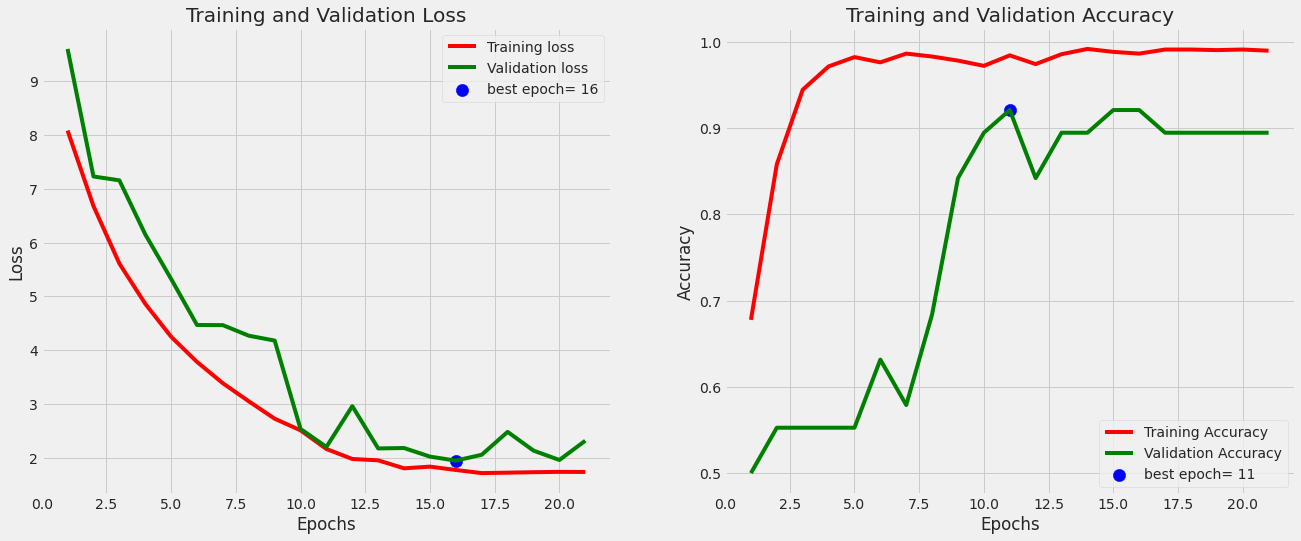

1/1 [==============================] - 0s 322ms/step - loss: 3.1263 - accuracy: 0.8378
Accuracy on the test set: 83.78 %



In [ ]:
tr_plot(history,0)
save_dir = r'./'
subject = 'label'
acc = model.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg = f'Accuracy on the test set: {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id = str(model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc = os.path.join(save_dir, save_id)
model.save(save_loc)

The model training is stopped after 21 epochs as the validation loss is not improving. From the plot of the training history, I'm a little suspecting that the model is over-fitting to the training data.

We can observe that the training accuracy increases rapidly after the 2nd epoch and stayed around 98~99% or higher. On the other hand, the validation accuracy started out at 50% and peaked around 92% while the validation loss continue to decrease.

#### Model Evaluation
After training, we can evaluate the model performance on the testing set.

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
            split1=os.path.split(file_names[i])                
            split2=os.path.split(split1[0])                
            fname=split2[1] + '/' + split1[1]
            shutil.copy(file_names[i], os.path.join("mispred_aug", fname))
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors > 0:
        plot_bar = []
        plot_class = []
        for  key, value in new_dict.items():        
            count = error_indices.count(key) 
            if count != 0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig = plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(c, x, )
            plt.title('Errors by Class on Test Set')
    y_true = np.array(labels)        
    y_pred = np.array(y_pred)
    if len(classes) <= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width = 8
            fig_height = 8
        else:
            fig_width = int(length * .5)
            fig_height = int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin = 0, fmt = 'g', cmap = 'Blues', cbar = False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [ ]:
print_code = 50
preds = model.predict(test_gen) 

          Filename                Predicted Class                True Class           Probability   

  OK/TW1YX13604131-143.jpg               NG                          OK                 1.0000

 NG/TW1YX13607960-1244.jpg               OK                          NG                 0.8846

    OK/TW1YX13606107.jpg                 NG                          OK                 0.9941

 OK/TW1YX13703125-2232.jpg               NG                          OK                 0.7942

 NG/TW1YX13607992-1279.jpg               OK                          NG                 0.5484



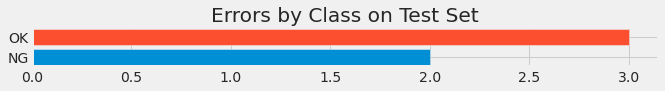

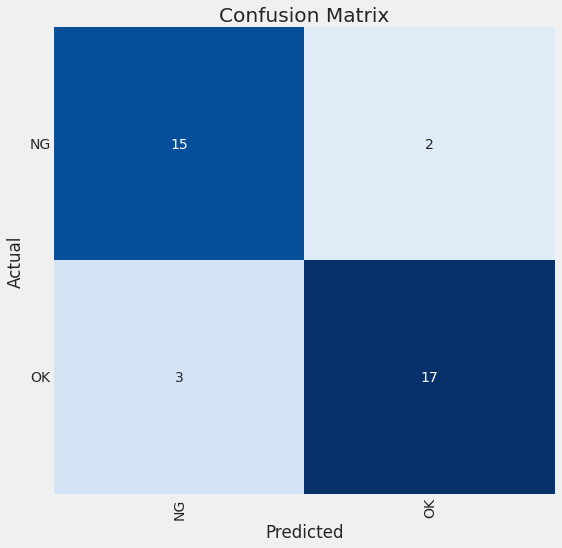

Classification Report:
----------------------
               precision    recall  f1-score   support

          NG       0.83      0.88      0.86        17
          OK       0.89      0.85      0.87        20

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



In [ ]:
print_info(test_gen, preds, print_code, save_dir, subject)

Based on the prediction matrix, we can see that the model is able to accurately classify 15 NG images and 17 OK images. 2 NG images are missed, and 3 OK images are mis-classified as NG.

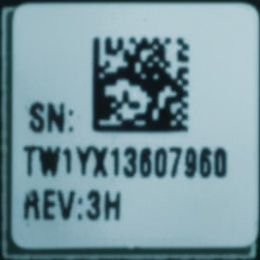

In [ ]:
# Mis-classified NG as OK
filename=os.path.join('mispred_aug', 'NG', 'TW1YX13607960-1244.jpg')
Image(filename=filename)

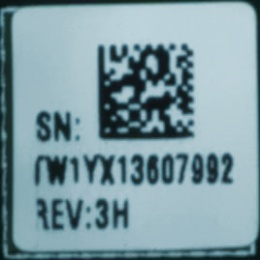

In [ ]:
# Mis-classified NG as OK
filename=os.path.join('mispred_aug', 'NG', 'TW1YX13607992-1279.jpg')
Image(filename=filename)

The 2 missed NG images can be viewed as difficult samples in the dataset because they only have very small defects in characters. In the 1st image, there is only a small part of the 'R' letter missing; in the 2nd image, part of the 'T' and 'R' letters cut off.

In overall, this baseline model achieves an accuracy of 86% on the testing set, which isn't exactly ideal in tackling difficult cases like the 2 missed images.

It is possible that the input size of 128 by 128 may have caused some loss of information when the original input image is resized. For instance, the missing part of 'R' might not be significant and obvious after the resize. In such case, a bigger input size may resolve the issue.

However, for the future experiments, I might want to try the typical defect detection structure of a detector plus classifier instead. Often in times a defect label can have multiple types of defects. Being able to collect such information may help with improving the label printing step and solving root causes of these label defects in the production process.